In [26]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

import pickle
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
import pickle

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation

In [49]:
class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self, z):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Velocity ###
            low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
            self.fictrac[short] = low_res_behavior#/np.std(low_res_behavior)

            ### Clipped Velocities ###
            self.fictrac[short + '_pos'] = np.clip(self.fictrac[short], a_min=0, a_max=None)
            self.fictrac[short + '_neg'] = np.clip(self.fictrac[short], a_min=None, a_max=0)*-1

            ### Acceleration ###
            high_res_behavior = self.pull_from_interp_object(interp_object, high_res_timepoints)
            self.fictrac[short + 'h'] = high_res_behavior#/np.std(high_res_behavior)

            ###################### these...
            # Pos Velocity
            temp = np.clip(high_res_behavior, a_min=0, a_max=None)
            accel = scipy.signal.savgol_filter(np.diff(temp),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a' + '_pos' + '_plus'] = np.clip(acl, a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_pos' + '_minus'] = np.clip(acl, a_min=None, a_max=0)*-1
            
            # Neg Velocity
            temp = np.clip(high_res_behavior, a_min=None, a_max=0)*-1
            accel = scipy.signal.savgol_filter(np.diff(temp),25,3)
            accel = np.append(accel, 0)
            interp_object = interp1d(high_res_timepoints, accel, bounds_error = False)
            acl = interp_object(self.timestamps[:,z])
            acl[-1] = 0
            self.fictrac[short + 'a' + '_neg' + '_plus'] = np.clip(acl, a_min=0, a_max=None)
            self.fictrac[short + 'a' + '_neg' + '_minus'] = np.clip(acl, a_min=None, a_max=0)*-1

            
            ### Clipped Acceleration ###
#             self.fictrac[short + 'a' + '_pos'] = np.clip(self.fictrac[short + 'a'], a_min=0, a_max=None)
#             self.fictrac[short + 'a' + '_neg'] = np.clip(self.fictrac[short + 'a'], a_min=None, a_max=0)*-1

#         self.fictrac['YZ'] = np.sqrt(np.power(self.fictrac['Y'],2), np.power(self.fictrac['Z'],2))
#         self.fictrac['YZh'] = np.sqrt(np.power(self.fictrac['Yh'],2), np.power(self.fictrac['Zh'],2))

In [50]:
save_directory = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20220123_accel_correlation/"
z=20

In [51]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

In [52]:
#######################
### Load Superslice ###
#######################
brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)
fly_idx_delete = 3 #(fly_095)
brain = np.delete(brain, fly_idx_delete, axis=-1) #### DELETING FLY_095 ####

In [53]:
brain.shape

(256, 128, 3384, 9)

In [55]:
n_clusters = 2000
#labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels_all = np.load(labels_file)
cluster_model_labels = cluster_model_labels_all[z,:]

In [56]:
###################
### Build Flies ###
###################
flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac(z)
    flies[fly].load_brain_slice()
    flies[fly].get_cluster_averages(cluster_model_labels, n_clusters)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 98.88 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.63 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 33.55 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.37 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 19.41 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.59 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 34.40 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.39 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 16.24 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 6.02 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 43.88

In [63]:
for z in tqdm(range(49)):
    
    ### Load Superslice ###
    brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z)
    brain = np.array(nib.load(brain_file).get_data(), copy=True)
    fly_idx_delete = 3 #(fly_095)
    brain = np.delete(brain, fly_idx_delete, axis=-1) #### DELETING FLY_095 ####
    
    ### Get Slice Supervoxel labels ###
    cluster_model_labels = cluster_model_labels_all[z,:]
    
    ### Interpolate behavior to this slice ###
    for i, fly in enumerate(fly_names):
        flies[fly].fictrac.interp_fictrac(z)
        flies[fly].load_brain_slice()
        flies[fly].get_cluster_averages(cluster_model_labels, n_clusters)
        
    ### Pool Behavior ###
    all_behaviors = [#'Ya_pos_plus', 'Ya_pos_minus',
                     'Za_pos_plus', 'Za_pos_minus',
                     'Za_neg_plus', 'Za_neg_minus']
    pooled_behavior = {}
    for j, behavior in enumerate(all_behaviors):
        pooled_behavior[behavior] = []
        for i,fly in enumerate(flies):
            pooled_behavior[behavior].append(flies[fly].fictrac.fictrac[behavior])
        pooled_behavior[behavior] = np.asarray(pooled_behavior[behavior]).flatten()
        
    
    ### Correlate ###
    for behavior_to_corr in all_behaviors:
        r_values = []
        p_values = []
        for cluster in range(n_clusters):
            pooled_activity = []
            for fly in flies:
                pooled_activity.append(flies[fly].cluster_signals[cluster])
            pooled_activity = np.asarray(pooled_activity).flatten()

            Y = pooled_activity
            X = pooled_behavior[behavior_to_corr]

            r, p = scipy.stats.pearsonr(X, Y)
            r_values.append(r)
            p_values.append(p)
    
        ### Save ###
        save_file = os.path.join(save_directory, 'rvalues_{}_z{}'.format(behavior_to_corr, z))
        np.save(save_file, np.asarray(r_values))

        save_file = os.path.join(save_directory, 'pvalues_{}_z{}'.format(behavior_to_corr, z))
        np.save(save_file, np.asarray(p_values))

100%|██████████| 49/49 [50:48<00:00, 67.09s/it]


In [43]:
a = flies['fly_087'].fictrac.fictrac['Zh']
b = np.clip(a, a_min=0, a_max=None)
c = np.clip(a, a_min=None, a_max=0)*-1

In [ ]:
np.clip(high_res_behavior, a_min=0, a_max=None)

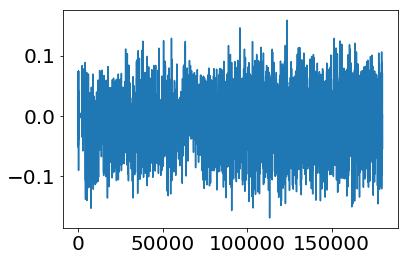

In [47]:
plt.plot(a)

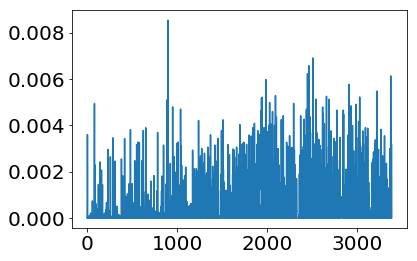

In [57]:
plt.plot(flies['fly_087'].fictrac.fictrac['Za_pos_plus'])

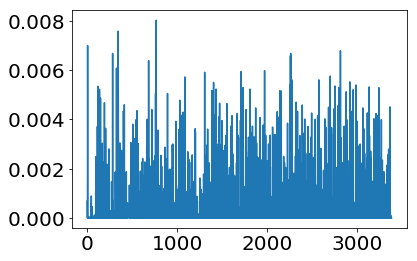

In [58]:
plt.plot(flies['fly_087'].fictrac.fictrac['Za_neg_plus'])

In [31]:
pooled_behavior['Za_pos_plus'][10000], pooled_behavior['Za_neg_plus'][10000]

(0.00044542331488095304, 0.00044542331488095304)

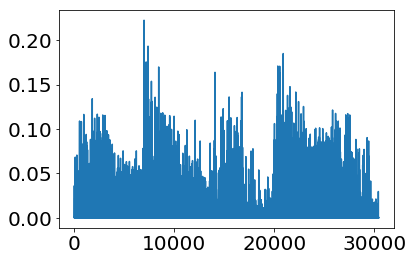

In [28]:
plt.plot(pooled_behavior['Za_pos_plus'])

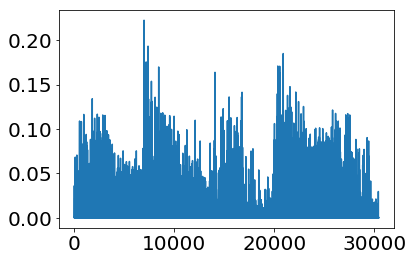

In [29]:
plt.plot(pooled_behavior['Za_neg_plus'])

In [59]:
#####################
### Pool behavior ###
#####################
# not_clipped_behaviors = ['Y', 'Z', 'Ya', 'Za']
# clipped_behaviors = ['Y_pos', 'Y_neg',
#                      'Z_pos', 'Z_neg',
#                      'Ya_pos', 'Ya_neg',
#                      'Za_pos', 'Za_neg']
# all_behaviors = not_clipped_behaviors + clipped_behaviors

all_behaviors = ['Za_pos_plus', 'Za_pos_minus', 'Za_neg_plus', 'Za_neg_minus']

pooled_behavior = {}
for j, behavior in enumerate(all_behaviors):
    pooled_behavior[behavior] = []
    for i,fly in enumerate(flies):
        pooled_behavior[behavior].append(flies[fly].fictrac.fictrac[behavior])
    pooled_behavior[behavior] = np.asarray(pooled_behavior[behavior]).flatten()

In [60]:
###################
### Correlation ###
###################

behavior_to_corr = 'Za_pos_plus'

r_values = []
p_values = []
for cluster in range(n_clusters):
    pooled_activity = []
    for fly in flies:
        pooled_activity.append(flies[fly].cluster_signals[cluster])
    pooled_activity = np.asarray(pooled_activity).flatten()

    Y = pooled_activity
    X = pooled_behavior[behavior_to_corr]

    r, p = scipy.stats.pearsonr(X, Y)
    r_values.append(r)
    p_values.append(p)

In [14]:
np.shape(r_values)

(2000,)

In [17]:
cluster_model_labels.shape

(32768,)

In [61]:
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
    colored_by_betas[cluster_indicies] = r_values[cluster_num]
colored_by_betas = colored_by_betas.reshape(256,128)

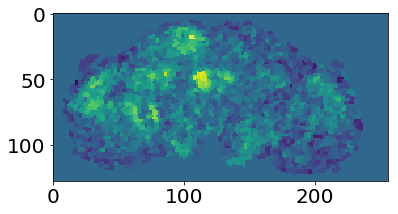

In [62]:
plt.imshow(colored_by_betas.T)